# Coursework 3: RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook with your answers. Write your answers in the cells below for each question.


## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the RNN tutorial: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding
In this part you will have to:

- Implement an LSTM
- Implement a GRU

### Part 2 - Theory

Here you will answer some theoretical questions about RNNs -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "/content/drive/My Drive/CW3/" # this should change depending on where you have stored the data files

### Initial code before coursework questions start:

In [3]:
import math
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [4]:
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [5]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [6]:

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Question 1:  Finalise the LSTM and GRU cells by completing the missing code

You are allowed to use nn.Linear.

In [7]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE - Question 1a) Complete the missing code
        ########################################################################

        self.x2h = nn.Linear(self.input_size, 4 * self.hidden_size, bias = self.bias)
        self.h2h = nn.Linear(self.hidden_size, 4 * self.hidden_size, bias = self.bias)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        # We used hx to pack both the hidden and cell states
        hx, cx = hx
        

        ########################################################################
        ## START OF YOUR CODE - Question 1b) Complete the missing code
        ########################################################################
        
        input = input.view(-1, input.size(1))
        gates = self.x2h(input) + self.h2h(hx)
        in_gate, for_gate, cell_gate, out_gate = gates.squeeze().chunk(4, dim = 1)

        # Gates
        for_gate =  torch.sigmoid(for_gate)
        in_gate = torch.sigmoid(in_gate)
        cell_gate = torch.mul(cx, for_gate) + torch.mul(in_gate, torch.tanh(cell_gate))
        out_gate = torch.sigmoid(out_gate)

        # Outputs
        cy = cell_gate
        hy = torch.mul(out_gate, torch.tanh(cy))
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        activation = getattr(nn.functional, self.nonlinearity)
        hy = activation(self.x2h(input) + self.h2h(hx))

        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE - Question 1c) Complete the missing code
        ########################################################################
        self.x2h = nn.Linear(self.input_size, 3 * self.hidden_size, bias = self.bias)
        self.h2h = nn.Linear(self.hidden_size, 3 * self.hidden_size, bias = self.bias) 
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE - Question 1d) Complete the missing code
        ########################################################################
        
        input = input.view(-1, input.size(1))
        gate_x, gate_h = self.x2h(input).squeeze(), self.h2h(hx).squeeze()

        xr, xu, xo =  gate_x.chunk(3, dim = 1)
        hr, hu, ho =  gate_h.chunk(3, dim = 1)

        # Gates
        res_gate = torch.sigmoid(xr + hr)
        upd_gate = torch.sigmoid(xu + hu)
        out_gate = torch.tanh(torch.mul(res_gate, hx) + xo)

        # Output
        hy =  torch.mul((1 - upd_gate), ho) + torch.mul(out_gate, upd_gate)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

### Question 2:  Finalise the RNNModel and BidirRecurrentModel

In [8]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE - Question 2a) Complete the missing code
        #
        #  Append the appropriate LSTM cells to rnn_cell_list
        ########################################################################
    
            self.rnn_cell_list.append(
                LSTMCell(self.input_size, self.hidden_size, self.bias)
            )
            
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    LSTMCell(self.hidden_size, self.hidden_size, self.bias)
                )   
                      
        ########################################################################
        ## END OF YOUR CODE
        ######################################################################## 

        elif mode == 'GRU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2b) Complete the missing code
        #
        #  Append the appropriate GRU cells to rnn_cell_list
        ########################################################################

            self.rnn_cell_list.append(
                GRUCell(self.input_size, self.hidden_size, self.bias)
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    GRUCell(self.hidden_size, self.hidden_size, self.bias)
                )

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################        
        
        elif mode == 'RNN_TANH':
            
                  
        ########################################################################
        ## START OF YOUR CODE - Question 2c) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            
            self.rnn_cell_list.append(
                BasicRNNCell(self.input_size, self.hidden_size, self.bias, "tanh")
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "tanh")
                )

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


                
        elif mode == 'RNN_RELU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2d) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            
            self.rnn_cell_list.append(
                BasicRNNCell(self.input_size, self.hidden_size, self.bias, "relu")
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "relu")
                )

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):

        outs = []
        h0 = [None] * self.num_layers if hx is None else list(hx)
        
        # In this forward pass we want to create our RNN from the rnn cells,
        # ..taking the hidden states from the final RNN layer and passing these 
        # ..through our fully connected layer (fc).
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE - Question 2e) Complete the missing code
        #
        #  HINT: You may need a special case for LSTMs
        ########################################################################

        ## LSTM SPECIAL CASE ##
        if self.mode is 'LSTM':
            
            # initialise c0
            if not isinstance(h0, tuple):
                c0 = Tensor(self.num_layers, input.size(0), self.hidden_size)
                h0 = Tensor(self.num_layers, input.size(0), self.hidden_size)
            # Initialise states. 
            hid_state, cell_state = [], []
            for l in range(self.num_layers):
                hid_state.append(h0[l, :, :])
                cell_state.append(c0[l, :, :])
            

            for ts in range(input.size(1)):
                for l in range(self.num_layers):
                    # First Layer
                    if l == 0:
                        hid_out, cell_out = self.rnn_cell_list[l](input[:, ts, :], (hid_state[l], cell_state[l]))
                    # Inner Layers
                    else:
                        hid_out, cell_out = self.rnn_cell_list[l](hid_state[l - 1], (hid_state[l], cell_state[l]))
                    
                    hid_state[l] = hid_out
                    cell_state[l] = cell_out
                outs.append(hid_out)

        ## OTHER CASES ##
        else:
            # Initialise hidden state.
            if hx is None :
                h0 = Tensor(self.num_layers, input.size(0), self.hidden_size)
            
            hid_state = [h0[l, :, :] for l in range(self.num_layers)]

            for ts in range(input.size(1)):
                for l in range(self.num_layers):
                    # First Layer
                    if l == 0:
                        hid_out = self.rnn_cell_list[l](input[:, ts, :], hid_state[l])
                    # Inner Layers
                    else:
                        hid_out = self.rnn_cell_list[l](hid_state[l - 1], hid_state[l])

                    hid_state[l] = hid_out

                outs.append(hid_out)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE - Question 2f) Complete the missing code
        #
        #  Create code for the following 'mode' values:
        # 'LSTM', 'GRU', 'RNN_TANH' and 'RNN_RELU'
        ########################################################################
        
        if mode == 'LSTM':
            self.rnn_cell_list.append(
                LSTMCell(self.input_size, self.hidden_size, self.bias)
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    LSTMCell(self.hidden_size, self.hidden_size, self.bias)
                )

        elif mode == 'GRU':
            self.rnn_cell_list.append(
                GRUCell(self.input_size, self.hidden_size, self.bias)
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    GRUCell(self.hidden_size, self.hidden_size, self.bias)
                )

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(
                BasicRNNCell(self.input_size, self.hidden_size, self.bias, "tanh")
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "tanh")
                )

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(
                BasicRNNCell(self.input_size, self.hidden_size, self.bias, "relu")
            )
            for _ in range(self.num_layers - 1):
                self.rnn_cell_list.append(
                    BasicRNNCell(self.hidden_size, self.hidden_size, self.bias, "relu")
                )
        else:
            raise ValueError("Invalid RNN mode selected.")
        
        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        
        # In this forward pass we want to create our Bidirectional RNN from the rnn cells,
        # .. taking the hidden states from the final RNN layer with their reversed counterparts
        # .. before concatening these and running them through the fully connected layer (fc)
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE  - Question 2g) Complete the missing code
        ########################################################################
        h0, hT = Tensor(self.num_layers, input.size(0), self.hidden_size), Tensor(self.num_layers, input.size(0), self.hidden_size)           
        
        outs, outs_rev = [], []

        ## LSTM SPECIAL CASE ##
        if self.mode is 'LSTM':
            # Initialise h0, hT, c0, cT.
            if not isinstance(h0, tuple):
                c0 = Tensor(self.num_layers, input.size(0), self.hidden_size)
                h0 = (h0, c0)
            if not isinstance(hT, tuple):
                cT = Tensor(self.num_layers, input.size(0), self.hidden_size)
                hT = (hT, cT)

            # Initialise states. 
            hid_forw, hid_back, cell_forw, cell_back = [], [], [], []

            for l in range(self.num_layers):  
                hid_forw.append(h0[0][l, :, :])
                hid_back.append(hT[0][l, :, :])
                cell_forw.append(h0[1][l, :, :])
                cell_back.append(hT[1][l, :, :])

            for ts in range(input.size(1)):
                for l in range(self.num_layers):
                    # First Layer.
                    if l == 0:
                        hid_out_forw, cell_out_forw = self.rnn_cell_list[l](input[:, ts, :], (hid_forw[l], cell_forw[l]))
                        hid_out_back, cell_out_back = self.rnn_cell_list[l](input[:, -(ts + 1), :], (hid_back[l], cell_back[l]))
                    
                    # Other Layers.
                    else:
                        hid_out_forw, cell_out_forw = self.rnn_cell_list[l](hid_forw[l - 1], (hid_forw[l], cell_forw[l]))
                        hid_out_back, cell_out_back = self.rnn_cell_list[l](hid_back[l - 1], (hid_back[l], cell_back[l]))
                                                                             
                    hid_forw[l] = hid_out_forw
                    hid_back[l] = hid_out_back
                    cell_forw[l] = cell_out_forw
                    cell_back[l] = cell_out_back

                outs.append(hid_out_forw)
                outs_rev.append(hid_out_back)

        ## OTHER CASE ##
        else: 
            # Initialise states. 
            hid_forw, hid_back = [], []

            for l in range(self.num_layers):  
                hid_forw.append(h0[l, :, :])
                hid_back.append(hT[l, :, :])


            for ts in range(input.size(1)):
                for l in range(self.num_layers):
                    # First Layer.
                    if l == 0:
                        hid_out_forw = self.rnn_cell_list[l](input[:, ts, :], hid_forw[l])
                        hid_out_back = self.rnn_cell_list[l](input[:, -(ts + 1), :], hid_back[l])
                    # Other Layers.
                    else:
                        hid_out_forw = self.rnn_cell_list[l](hid_forw[l - 1], hid_forw[l])
                        hid_out_back = self.rnn_cell_list[l](hid_back[l - 1], hid_back[l])

                    hid_forw[l] = hid_out_forw
                    hid_back[l] = hid_out_back

                outs.append(hid_out_forw)
                outs_rev.append(hid_out_back)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

The code below trains a network based on your code above. This should work without error:

In [13]:
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 32
layer_dim = 3
bias = True

##############################################
### Change the code below to try running different models:
mtype = 'Bidir' # ['Bidir' or 'RNN'] 
subtype = 'LSTM'  # ['GRU', 'LSTM', 'RNN_RELU', or 'RNN_TANH']

if mtype is 'RNN':
    model = RNNModel(subtype, input_dim, hidden_dim, layer_dim, bias, output_dim)
else:
    model = BidirRecurrentModel(subtype, input_dim, hidden_dim, layer_dim, bias, output_dim)

print(mtype + '-' + subtype)
########################################
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
v_acc_list = []
t_acc_list = []

iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct // total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct // total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))

Bidir-LSTM
Iteration: 20. Loss: 1.0880045890808105. V-Accuracy: 48  T-Accuracy: 49
Iteration: 40. Loss: 0.8832895755767822. V-Accuracy: 65  T-Accuracy: 56
Iteration: 60. Loss: 0.7956854104995728. V-Accuracy: 75  T-Accuracy: 72
Iteration: 80. Loss: 0.6850116848945618. V-Accuracy: 65  T-Accuracy: 72
Iteration: 100. Loss: 0.6331068277359009. V-Accuracy: 76  T-Accuracy: 74
Iteration: 120. Loss: 0.5043777227401733. V-Accuracy: 75  T-Accuracy: 74
Iteration: 140. Loss: 0.4193473160266876. V-Accuracy: 82  T-Accuracy: 76
Iteration: 160. Loss: 0.3989869952201843. V-Accuracy: 85  T-Accuracy: 76
Iteration: 180. Loss: 0.48398131132125854. V-Accuracy: 84  T-Accuracy: 76
Iteration: 200. Loss: 0.4456329643726349. V-Accuracy: 87  T-Accuracy: 86
Iteration: 220. Loss: 0.35826030373573303. V-Accuracy: 86  T-Accuracy: 86
Iteration: 240. Loss: 0.2761075496673584. V-Accuracy: 84  T-Accuracy: 86
Iteration: 260. Loss: 0.45013171434402466. V-Accuracy: 87  T-Accuracy: 87
Iteration: 280. Loss: 0.6767653822898865.

## **OUTPUT FULL METHODS LOOP**

###################################

model:  RNN  ( GRU )

###################################

Iteration: 20. Loss: 0.9561302065849304. V-Accuracy: 53  T-Accuracy: 54

Iteration: 40. Loss: 0.8903473615646362. V-Accuracy: 59  T-Accuracy: 58

Iteration: 60. Loss: 0.7543816566467285. V-Accuracy: 70  T-Accuracy: 68

Iteration: 80. Loss: 0.725848913192749. V-Accuracy: 66  T-Accuracy: 68

Iteration: 100. Loss: 0.7636039853096008. V-Accuracy: 73  T-Accuracy: 73

Iteration: 120. Loss: 0.6793885827064514. V-Accuracy: 78  T-Accuracy: 77

Iteration: 140. Loss: 0.7113931775093079. V-Accuracy: 67  T-Accuracy: 77

Iteration: 160. Loss: 0.40513619780540466. V-Accuracy: 86  T-Accuracy: 81

Iteration: 180. Loss: 0.6866018772125244. V-Accuracy: 86  T-Accuracy: 83

Iteration: 200. Loss: 0.5102830529212952. V-Accuracy: 85  T-Accuracy: 83

Iteration: 220. Loss: 0.4704033136367798. V-Accuracy: 87  T-Accuracy: 84

Iteration: 240. Loss: 0.3365325927734375. V-Accuracy: 88  T-Accuracy: 85

Iteration: 260. Loss: 0.33631762862205505. V-Accuracy: 86  T-Accuracy: 85

Iteration: 280. Loss: 0.8429006338119507. V-Accuracy: 66  T-Accuracy: 85

Iteration: 300. Loss: 0.5694798231124878. V-Accuracy: 85  T-Accuracy: 85

Iteration: 320. Loss: 0.33215010166168213. V-Accuracy: 89  T-Accuracy: 84

Iteration: 340. Loss: 0.3906973600387573. V-Accuracy: 84  T-Accuracy: 84

Iteration: 360. Loss: 0.6969985365867615. V-Accuracy: 83  T-Accuracy: 84

Iteration: 380. Loss: 0.49432504177093506. V-Accuracy: 83  T-Accuracy: 84

Iteration: 400. Loss: 0.5342686176300049. V-Accuracy: 87  T-Accuracy: 84

Iteration: 420. Loss: 0.2631254196166992. V-Accuracy: 91  T-Accuracy: 83

Iteration: 440. Loss: 0.37308886647224426. V-Accuracy: 73  T-Accuracy: 83

Iteration: 460. Loss: 0.40407443046569824. V-Accuracy: 92  T-Accuracy: 83

###################################

model:  RNN  ( RNN_TANH )

###################################

Iteration: 20. Loss: 1.1034154891967773. V-Accuracy: 32  T-Accuracy: 33

Iteration: 40. Loss: 1.1023716926574707. V-Accuracy: 33  T-Accuracy: 32

Iteration: 60. Loss: 1.1075751781463623. V-Accuracy: 35  T-Accuracy: 35

Iteration: 80. Loss: 1.0769954919815063. V-Accuracy: 38  T-Accuracy: 37

Iteration: 100. Loss: 0.9899902939796448. V-Accuracy: 40  T-Accuracy: 41

Iteration: 120. Loss: 1.1329196691513062. V-Accuracy: 42  T-Accuracy: 41

Iteration: 140. Loss: 0.9478765726089478. V-Accuracy: 50  T-Accuracy: 47

Iteration: 160. Loss: 1.051822304725647. V-Accuracy: 45  T-Accuracy: 47

Iteration: 180. Loss: 1.129467487335205. V-Accuracy: 33  T-Accuracy: 47

Iteration: 200. Loss: 1.1145861148834229. V-Accuracy: 32  T-Accuracy: 47

Iteration: 220. Loss: 1.0968570709228516. V-Accuracy: 33  T-Accuracy: 47

Iteration: 240. Loss: 1.104008674621582. V-Accuracy: 33  T-Accuracy: 47

Iteration: 260. Loss: 1.0980571508407593. V-Accuracy: 32  T-Accuracy: 47

Iteration: 280. Loss: 1.0927002429962158. V-Accuracy: 32  T-Accuracy: 47

Iteration: 300. Loss: 1.1269519329071045. V-Accuracy: 33  T-Accuracy: 47

Iteration: 320. Loss: 1.088649034500122. V-Accuracy: 32  T-Accuracy: 47

Iteration: 340. Loss: 1.0880463123321533. V-Accuracy: 33  T-Accuracy: 47

Iteration: 360. Loss: 1.1037602424621582. V-Accuracy: 33  T-Accuracy: 47

Iteration: 380. Loss: 1.0995049476623535. V-Accuracy: 33  T-Accuracy: 47

Iteration: 400. Loss: 1.0915759801864624. V-Accuracy: 32  T-Accuracy: 47

Iteration: 420. Loss: 1.1071443557739258. V-Accuracy: 33  T-Accuracy: 47

Iteration: 440. Loss: 1.0978683233261108. V-Accuracy: 32  T-Accuracy: 47

Iteration: 460. Loss: 1.1074892282485962. V-Accuracy: 33  T-Accuracy: 47

###################################

model:  RNN  ( RNN_RELU )

###################################

Iteration: 20. Loss: 1.1160707473754883. V-Accuracy: 33  T-Accuracy: 34

Iteration: 40. Loss: 1.1022683382034302. V-Accuracy: 37  T-Accuracy: 37

Iteration: 60. Loss: 0.9832788109779358. V-Accuracy: 44  T-Accuracy: 44

Iteration: 80. Loss: 1.0721312761306763. V-Accuracy: 47  T-Accuracy: 46

Iteration: 100. Loss: 1.015217661857605. V-Accuracy: 50  T-Accuracy: 50

Iteration: 120. Loss: 0.9001149535179138. V-Accuracy: 58  T-Accuracy: 56

Iteration: 140. Loss: 0.7910499572753906. V-Accuracy: 59  T-Accuracy: 59

Iteration: 160. Loss: 0.9348728656768799. V-Accuracy: 57  T-Accuracy: 59

Iteration: 180. Loss: 0.8693548440933228. V-Accuracy: 57  T-Accuracy: 59

Iteration: 200. Loss: 0.9384353160858154. V-Accuracy: 60  T-Accuracy: 59

Iteration: 220. Loss: 0.7689361572265625. V-Accuracy: 60  T-Accuracy: 58

Iteration: 240. Loss: 0.7847061157226562. V-Accuracy: 60  T-Accuracy: 60

Iteration: 260. Loss: 0.985332727432251. V-Accuracy: 50  T-Accuracy: 60

Iteration: 280. Loss: 0.723987877368927. V-Accuracy: 63  T-Accuracy: 59

Iteration: 300. Loss: 0.7841731905937195. V-Accuracy: 64  T-Accuracy: 60

Iteration: 320. Loss: 0.8351468443870544. V-Accuracy: 62  T-Accuracy: 60

Iteration: 340. Loss: 0.9058837294578552. V-Accuracy: 64  T-Accuracy: 59

Iteration: 360. Loss: 1.2709904909133911. V-Accuracy: 34  T-Accuracy: 59

Iteration: 380. Loss: 1.0990158319473267. V-Accuracy: 35  T-Accuracy: 59

Iteration: 400. Loss: 1.082330346107483. V-Accuracy: 38  T-Accuracy: 59

Iteration: 420. Loss: 1.037419319152832. V-Accuracy: 42  T-Accuracy: 59

Iteration: 440. Loss: 1.0708616971969604. V-Accuracy: 35  T-Accuracy: 59

Iteration: 460. Loss: 1.1028510332107544. V-Accuracy: 34  T-Accuracy: 59

###################################

model:  RNN  ( LSTM )

###################################

Iteration: 20. Loss: 0.9689067006111145. V-Accuracy: 45  T-Accuracy: 48

Iteration: 40. Loss: 0.8540774583816528. V-Accuracy: 53  T-Accuracy: 51

Iteration: 60. Loss: 0.9191190600395203. V-Accuracy: 61  T-Accuracy: 56

Iteration: 80. Loss: 0.7445234656333923. V-Accuracy: 64  T-Accuracy: 60

Iteration: 100. Loss: 0.6875060200691223. V-Accuracy: 67  T-Accuracy: 65

Iteration: 120. Loss: 0.7437916398048401. V-Accuracy: 66  T-Accuracy: 65

Iteration: 140. Loss: 0.6558486819267273. V-Accuracy: 71  T-Accuracy: 69

Iteration: 160. Loss: 0.46583274006843567. V-Accuracy: 76  T-Accuracy: 72

Iteration: 180. Loss: 0.5896034836769104. V-Accuracy: 76  T-Accuracy: 75

Iteration: 200. Loss: 0.3904416561126709. V-Accuracy: 79  T-Accuracy: 77

Iteration: 220. Loss: 0.5140407681465149. V-Accuracy: 80  T-Accuracy: 75

Iteration: 240. Loss: 0.405274897813797. V-Accuracy: 83  T-Accuracy: 78

Iteration: 260. Loss: 0.33620724081993103. V-Accuracy: 84  T-Accuracy: 81

Iteration: 280. Loss: 1.4087907075881958. V-Accuracy: 87  T-Accuracy: 85

Iteration: 300. Loss: 0.31805211305618286. V-Accuracy: 86  T-Accuracy: 85

Iteration: 320. Loss: 0.3473026752471924. V-Accuracy: 88  T-Accuracy: 86

Iteration: 340. Loss: 0.3639087677001953. V-Accuracy: 86  T-Accuracy: 86

Iteration: 360. Loss: 0.27549317479133606. V-Accuracy: 87  T-Accuracy: 86

Iteration: 380. Loss: 0.19240999221801758. V-Accuracy: 87  T-Accuracy: 86

Iteration: 400. Loss: 0.25700074434280396. V-Accuracy: 90  T-Accuracy: 89

Iteration: 420. Loss: 0.264613538980484. V-Accuracy: 89  T-Accuracy: 89

Iteration: 440. Loss: 0.2183198481798172. V-Accuracy: 89  T-Accuracy: 89

Iteration: 460. Loss: 0.21509842574596405. V-Accuracy: 90  T-Accuracy: 89

###################################

model:  Bidir  ( GRU )

###################################

Iteration: 20. Loss: 1.082274079322815. V-Accuracy: 34  T-Accuracy: 35

Iteration: 40. Loss: 1.0125548839569092. V-Accuracy: 48  T-Accuracy: 46

Iteration: 60. Loss: 1.007194995880127. V-Accuracy: 48  T-Accuracy: 38

Iteration: 80. Loss: 0.8286391496658325. V-Accuracy: 52  T-Accuracy: 55

Iteration: 100. Loss: 0.8215748071670532. V-Accuracy: 58  T-Accuracy: 55

Iteration: 120. Loss: 0.8333355188369751. V-Accuracy: 60  T-Accuracy: 55

Iteration: 140. Loss: 0.7375155687332153. V-Accuracy: 63  T-Accuracy: 58

Iteration: 160. Loss: 0.6307977437973022. V-Accuracy: 76  T-Accuracy: 71

Iteration: 180. Loss: 0.7073248028755188. V-Accuracy: 76  T-Accuracy: 68

Iteration: 200. Loss: 0.446061372756958. V-Accuracy: 73  T-Accuracy: 68

Iteration: 220. Loss: 0.6377752423286438. V-Accuracy: 79  T-Accuracy: 74

Iteration: 240. Loss: 0.505688488483429. V-Accuracy: 84  T-Accuracy: 81

Iteration: 260. Loss: 0.3450552821159363. V-Accuracy: 81  T-Accuracy: 81

Iteration: 280. Loss: 1.7131747007369995. V-Accuracy: 83  T-Accuracy: 81

Iteration: 300. Loss: 0.586900532245636. V-Accuracy: 69  T-Accuracy: 81

Iteration: 320. Loss: 0.6373705863952637. V-Accuracy: 59  T-Accuracy: 81

Iteration: 340. Loss: 0.6916649341583252. V-Accuracy: 75  T-Accuracy: 81

Iteration: 360. Loss: 0.5692563056945801. V-Accuracy: 78  T-Accuracy: 81

Iteration: 380. Loss: 0.5596460700035095. V-Accuracy: 75  T-Accuracy: 81

Iteration: 400. Loss: 0.35022827982902527. V-Accuracy: 72  T-Accuracy: 81

Iteration: 420. Loss: 0.5246718525886536. V-Accuracy: 69  T-Accuracy: 81

Iteration: 440. Loss: 0.46353092789649963. V-Accuracy: 77  T-Accuracy: 81

Iteration: 460. Loss: 0.7363241314888. V-Accuracy: 68  T-Accuracy: 81

###################################

model:  Bidir  ( RNN_TANH )

###################################

Iteration: 20. Loss: 1.0600533485412598. V-Accuracy: 40  T-Accuracy: 42

Iteration: 40. Loss: 0.9307008981704712. V-Accuracy: 53  T-Accuracy: 51

Iteration: 60. Loss: 1.0950218439102173. V-Accuracy: 28  T-Accuracy: 51

Iteration: 80. Loss: 1.0032471418380737. V-Accuracy: 50  T-Accuracy: 51

Iteration: 100. Loss: 0.8337976336479187. V-Accuracy: 52  T-Accuracy: 51

Iteration: 120. Loss: 0.9974746108055115. V-Accuracy: 53  T-Accuracy: 43

Iteration: 140. Loss: 1.0363726615905762. V-Accuracy: 55  T-Accuracy: 54

Iteration: 160. Loss: 1.0442838668823242. V-Accuracy: 24  T-Accuracy: 54

Iteration: 180. Loss: 1.0963218212127686. V-Accuracy: 41  T-Accuracy: 54

Iteration: 200. Loss: 1.0836025476455688. V-Accuracy: 42  T-Accuracy: 54

Iteration: 220. Loss: 1.0931051969528198. V-Accuracy: 36  T-Accuracy: 54

Iteration: 240. Loss: 1.0952160358428955. V-Accuracy: 41  T-Accuracy: 54

Iteration: 260. Loss: 1.1297619342803955. V-Accuracy: 34  T-Accuracy: 54

Iteration: 280. Loss: 1.0949240922927856. V-Accuracy: 23  T-Accuracy: 54

Iteration: 300. Loss: 1.0840860605239868. V-Accuracy: 42  T-Accuracy: 54

Iteration: 320. Loss: 1.1004750728607178. V-Accuracy: 30  T-Accuracy: 54

Iteration: 340. Loss: 1.1231616735458374. V-Accuracy: 37  T-Accuracy: 54

Iteration: 360. Loss: 1.1150280237197876. V-Accuracy: 29  T-Accuracy: 54

Iteration: 380. Loss: 1.0853084325790405. V-Accuracy: 35  T-Accuracy: 54

Iteration: 400. Loss: 1.1015141010284424. V-Accuracy: 32  T-Accuracy: 54

Iteration: 420. Loss: 1.0788109302520752. V-Accuracy: 31  T-Accuracy: 54

Iteration: 440. Loss: 1.0989362001419067. V-Accuracy: 29  T-Accuracy: 54

Iteration: 460. Loss: 1.1017906665802002. V-Accuracy: 29  T-Accuracy: 54

###################################

model:  Bidir  ( RNN_RELU )

###################################

Iteration: 20. Loss: 1.2428104877471924. V-Accuracy: 27  T-Accuracy: 31

Iteration: 40. Loss: 1.167560338973999. V-Accuracy: 33  T-Accuracy: 32

Iteration: 60. Loss: 1.1014034748077393. V-Accuracy: 31  T-Accuracy: 32

Iteration: 80. Loss: 1.3137356042861938. V-Accuracy: 42  T-Accuracy: 38

Iteration: 100. Loss: 3.692464590072632. V-Accuracy: 47  T-Accuracy: 37

Iteration: 120. Loss: 1.1070826053619385. V-Accuracy: 32  T-Accuracy: 37

Iteration: 140. Loss: 1.095628261566162. V-Accuracy: 43  T-Accuracy: 37

Iteration: 160. Loss: 1.0934882164001465. V-Accuracy: 22  T-Accuracy: 37

Iteration: 180. Loss: 1.0750423669815063. V-Accuracy: 38  T-Accuracy: 37

Iteration: 200. Loss: 1.6348724365234375. V-Accuracy: 39  T-Accuracy: 37

Iteration: 220. Loss: 1.0990155935287476. V-Accuracy: 36  T-Accuracy: 37

Iteration: 240. Loss: 1.0894988775253296. V-Accuracy: 47  T-Accuracy: 35

Iteration: 260. Loss: 1.0651038885116577. V-Accuracy: 39  T-Accuracy: 35

Iteration: 280. Loss: 1.7165340185165405. V-Accuracy: 55  T-Accuracy: 43

Iteration: 300. Loss: 1.06891667842865. V-Accuracy: 51  T-Accuracy: 43

Iteration: 320. Loss: 0.9782555103302002. V-Accuracy: 48  T-Accuracy: 43

Iteration: 340. Loss: 0.9224450588226318. V-Accuracy: 55  T-Accuracy: 60

Iteration: 360. Loss: 0.8667580485343933. V-Accuracy: 55  T-Accuracy: 54

Iteration: 380. Loss: 1.2040129899978638. V-Accuracy: 52  T-Accuracy: 54

Iteration: 400. Loss: 0.8255164623260498. V-Accuracy: 56  T-Accuracy: 56

Iteration: 420. Loss: 0.7952700257301331. V-Accuracy: 62  T-Accuracy: 60

Iteration: 440. Loss: 0.7607876658439636. V-Accuracy: 59  T-Accuracy: 60

Iteration: 460. Loss: 0.7386267781257629. V-Accuracy: 62  T-Accuracy: 61

###################################

model:  Bidir  ( LSTM )

###################################

Iteration: 20. Loss: 1.0815420150756836. V-Accuracy: 44  T-Accuracy: 44

Iteration: 40. Loss: 0.9737756252288818. V-Accuracy: 55  T-Accuracy: 55

Iteration: 60. Loss: 0.6422842144966125. V-Accuracy: 70  T-Accuracy: 66

Iteration: 80. Loss: 0.6436399221420288. V-Accuracy: 72  T-Accuracy: 72

Iteration: 100. Loss: 0.6127040386199951. V-Accuracy: 80  T-Accuracy: 76

Iteration: 120. Loss: 0.6081951260566711. V-Accuracy: 79  T-Accuracy: 76

Iteration: 140. Loss: 0.6227766275405884. V-Accuracy: 82  T-Accuracy: 75

Iteration: 160. Loss: 0.5575412511825562. V-Accuracy: 82  T-Accuracy: 78

Iteration: 180. Loss: 0.4511949419975281. V-Accuracy: 84  T-Accuracy: 82

Iteration: 200. Loss: 0.47779110074043274. V-Accuracy: 84  T-Accuracy: 83

Iteration: 220. Loss: 0.41322407126426697. V-Accuracy: 84  T-Accuracy: 81

Iteration: 240. Loss: 0.39210444688796997. V-Accuracy: 86  T-Accuracy: 85

Iteration: 260. Loss: 0.5487701892852783. V-Accuracy: 87  T-Accuracy: 84

Iteration: 280. Loss: 0.6673308610916138. V-Accuracy: 85  T-Accuracy: 84

Iteration: 300. Loss: 0.22544078528881073. V-Accuracy: 85  T-Accuracy: 84

Iteration: 320. Loss: 0.2531524896621704. V-Accuracy: 88  T-Accuracy: 88

Iteration: 340. Loss: 0.1854662150144577. V-Accuracy: 91  T-Accuracy: 89

Iteration: 360. Loss: 0.27197912335395813. V-Accuracy: 92  T-Accuracy: 91

Iteration: 380. Loss: 0.16271835565567017. V-Accuracy: 90  T-Accuracy: 91

Iteration: 400. Loss: 0.28810369968414307. V-Accuracy: 91  T-Accuracy: 91

Iteration: 420. Loss: 0.30318590998649597. V-Accuracy: 91  T-Accuracy: 91

Iteration: 440. Loss: 0.23977068066596985. V-Accuracy: 93  T-Accuracy: 92

Iteration: 460. Loss: 0.19958242774009705. V-Accuracy: 92  T-Accuracy: 92

## Part 2: Theoretical questions

#### Theory question 1: 
What is the _vanishing gradients problem_ and why does it occur? Which activation functions are more or less impacted by this, and why?

#### Your answers:
* Your answer here describing vanishing gradients problem
* Two examples of activation functions more impacted by vanishing gradients
* Two examples of activation functions less impacted by vanishing gradients, why are they impacted less?


**MY ANSWER**

The vanishing gradient problem can be observed when early layers of neural networks utilise learning rates that tend to 0, hence learning very slowly. This effect is due to the usage of series of layers with certain activation functions that take small values when derivated. Two examples of such activation functions are *sigmoid* and *tanh*, which derivated cannot take a larger value than 1/4 and 1 respectively. Therefore when the weights are updated through back propagation, earlier layers will be calculated chaining multiple of these derivatives as for the chain rule, hence reducing more and more in magnitude. Coping with such an issue is fundamental as earlier layers learn core features and information on the data, therefore having a vanishing gradient often results in significant decreases in performance. 

There are some activation functions that can be utilised to mitigate the problem, namely activation functions which derivated do not turn close to zero.
*RELU* activation when derivated becomes the Heaviside step functions, which is constant at 1 for the positive x plane while equal to 0 for negative values. This would ensure a non vanishing behaviour for positive values, while not learning at all with a gradient of 0 for negative values. The *LeakyRELU* activation solves this additional problem introducing a small gradient for negative cases.

#### Theory question 2: 
Why do LSTMs help address the vanishing gradient problem compared to a vanilla RNN?


**MY ANSWER**

One of the tecniques to mitigate vanishing gradients is using gating units, such as in LSTMs. LSTM models compared to vanilla RNN controll the changes in gradients through separate gate units. THe forget gate allows information to flow to the next time step, hence providing a sort of "memory" of information seen in the past to the network. Furtheremore, cell state gradient is updated additively, which massively helps in guiding the gradient magnitude not towards a vanishing/exploding trend. 


#### Theory question 3: 

The plot below shows the training curves for three models A, B, and C, trained on the same dataset up to 100 epochs. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.

(In the cell below please set the values for A_model, B_model and C_model to be 'RNN', 'LSTM' or 'GRU'. This needs to be exact for the automatic marking.)

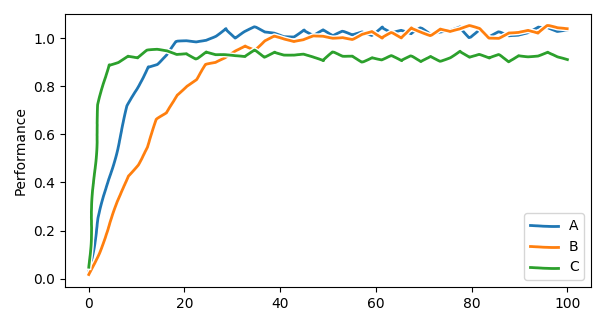

In [10]:
from IPython.display import Image, display
display(Image(filename= dataset_folder + 'Performance by epoch.png', width=550))

In [11]:
# Answers below:

A_model = 'GRU'
B_model = 'LSTM'
C_model = 'RNN'

# Give your reasons below:

**MY ANSWER**

The three curves visualised in the plot above show three different trends that have similarly been observed in testing various models. Starting from the less performant model (C) we can safely assume it to be the result of an RNN model, as the worse performance likely comes from it suffering of vanishing grandients as discussed in previous sections.
The other two curves instead can be differentiated by looking at the learning speed. GRU has a fairly simpler architecture and therefore should learn significantly faster than more complex architectures such as LSTM. For this reason I labelled the slow learning curve (B) as LSTM and (A) as GRU.

#### Theory question 4: 

When might you choose to use each of the three different types of models?

#### Your answers:
* Type of problem when best to use vanilla RNN:
* Type of problem to use GRU:
* Type of problem to use LSTM:


**MY ANSWER**

*RNN*

As LSTM and GRU mitigate the vanishing gradient problem, it is fairly uncommon to find use-cases in which RNN performs better than the other methods mentioned.
However due to its simple architecture, for some extremely simple tasks it might achieve similar performances. In that case one might prefer a much simpler architecture like RNN over more complex ones due to computational complexity constraints.

*GRU*

Generally GRU and LSTM performances are comparable. Hence for tasks in which the network does not benefit in having a very good "memory/recall" of long past information, GRU can be a better choice due to computational complexity, as it is faster than LSTM due to its simpler architecture.

*LSTM*

As mentioned in the previous paragraph, LSTM would instead be the best choice when the data presents long-term correlations which might be picked up only by LSTM gates.